Install Packages and Set Up Environment

In [15]:
# print working directory
!pwd

# List files and folders
!ls

# Check the open jdk version on colab
!ls /usr/lib/jvm/

/content
drive	     spark-3.0.0-bin-hadoop3.2	    spark-3.0.0-bin-hadoop3.2.tgz.1
sample_data  spark-3.0.0-bin-hadoop3.2.tgz
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
java-11-openjdk-amd64	   java-8-openjdk-amd64


In [16]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Download and install Java 8
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,150 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,334 kB]
Fetched 4,823 kB i

In [3]:
# Check if we have java 8 or not
!ls /usr/lib/jvm/

java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
java-11-openjdk-amd64	   java-8-openjdk-amd64


In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=08914bac14e3ce0b8323951d80d47fd21a8134bb2c9d0ee96348b0e9d4d40e0a
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [6]:
# Download Spark and Hadoop
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [9]:
!pip install -q findspark

In [10]:
import findspark
findspark.init()

In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .getOrCreate()

In [12]:
spark

In [13]:
!pwd
!ls

/content
sample_data		   spark-3.0.0-bin-hadoop3.2.tgz
spark-3.0.0-bin-hadoop3.2  spark-3.0.0-bin-hadoop3.2.tgz.1


Streaming Analysis

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType
from pyspark.sql.functions import col, lit, sum
import time

# create SparkSession
spark = SparkSession.builder.appName("myApp").getOrCreate()

# define the schema for the DataFrame
schema = StructType([
    StructField("team", StringType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("text", StringType(), True),
    StructField("location", StringType(), True),
    StructField("likes", IntegerType(), True),
    StructField("sentiment", IntegerType(), True)
])

csvpath = "/content/drive/MyDrive/Colab Notebooks/dataset/mergedAll.csv"

# read CSV file into DataFrame with specified schema
df = spark.read.csv(csvpath, header=False, schema=schema)

# perform data preprocessing

# remove rows with null values for location, sentiment, and likes
df = df.na.drop(subset=["location", "sentiment", "likes"])

# remove rows with location = "No location available"
# df = df.filter(df["location"] != "No location available.")

# remove rows with null timestamp
df = df.na.drop(subset=["timestamp"])

# convert timestamp column to timestamp datatype
df = df.withColumn("timestamp", df["timestamp"].cast("timestamp"))

# display resulting DataFrame
df.show()

+-----+-------------------+--------------------+--------------------+-----+---------+
| team|          timestamp|                text|            location|likes|sentiment|
+-----+-------------------+--------------------+--------------------+-----+---------+
|76ers|2023-04-21 22:25:50|I can’t wear an n...|No location avail...|    1|       -1|
|76ers|2023-04-21 21:50:10|RT @Hayes_BHCSpor...|No location avail...|    0|        1|
|76ers|2023-04-21 21:18:28|MVP #76ers https:...|No location avail...|    0|        0|
|76ers|2023-04-21 21:10:10|How has your favo...|No location avail...|    0|        1|
|76ers|2023-04-21 20:40:18|See you in Game 4...|No location avail...|    0|        1|
|76ers|2023-04-21 20:09:11|Should Embiid bee...|No location avail...|    0|        0|
|76ers|2023-04-21 20:00:28|Hoping #NBA suspe...|No location avail...|    0|        1|
|76ers|2023-04-21 19:24:43|The #NBA is takin...|No location avail...|    2|       -1|
|76ers|2023-04-21 19:14:13|RT @NYPost_Lewis:...|No loc

Fusion Optimization

In [29]:
# Fusion optimization: the performance of individual operations is often less important than the ability to perform many operations in parallel.

# filter tweets by team name
# df = df.filter((df["team"] == "ClevelandCavaliers") | (df["team"] == "Knicks"))

# measure execution time of original code
start_time_orig = time.time()

# filter timestamp column between two specific timestamps
start_timestamp = "2023-04-13 00:00:00"
end_timestamp = "2023-04-21 23:59:59"
filtered_df = df.filter(col("timestamp").between(lit(start_timestamp), lit(end_timestamp)))

# group data by location and calculate total likes
likes_by_location = df.groupBy("location").agg(sum("likes").alias("total_likes"))

# time without fusion
print("Without Fusion: %s seconds" % (time.time() - start_time_orig))

# measure execution time of modified code with fusion
start_time_fusion = time.time()

# applying fusion method
df_agg = df.filter(col("timestamp").between(lit(start_timestamp), lit(end_timestamp))) \
           .groupBy("location") \
           .agg(sum("likes").alias("total_likes"))

# time with fusion
print("With Fusion: %s seconds" % (time.time() - start_time_fusion))

Without Fusion: 0.09097981452941895 seconds
With Fusion: 0.05688047409057617 seconds


Reorder Optimization

In [30]:
# Reorder optimization: put filters with greater selectivity at the beginning to reduce the amount of time and resources required to execute a program.

# measure runtime of modified code with same filter as reordered code
start_time_mod = time.time()

df_filtered = df.filter(col("location").isNotNull() & col("sentiment").isNotNull() & col("likes").isNotNull() & col("timestamp").isNotNull())
df_grouped = df_filtered.groupBy("location").agg(sum("likes").alias("total_likes"))
df_filtered = df_grouped.filter(col("total_likes") > 0)

# time without reordering
print("Without reordering: %s seconds" % (time.time() - start_time_mod))

# measure runtime of reordered code
start_time_re = time.time()

df_grouped = df.groupBy("location").agg(sum("likes").alias("total_likes"))
df_filtered = df_grouped.filter(col("total_likes") > 0)
df_filtered = df.filter(col("location").isNotNull() & col("sentiment").isNotNull() & col("likes").isNotNull() & col("timestamp").isNotNull())

# time with reordering
print("Reordereing: %s seconds" % (time.time() - start_time_re))

Without reordering: 0.06523704528808594 seconds
Reordereing: 0.06477713584899902 seconds


More Streaming Processing

In [31]:
from pyspark.sql.functions import when

# replace -1 values in likes column with 0 because -1 means users hide like info
df = df.withColumn("likes", when(df["likes"] == -1, 0).otherwise(df["likes"]))
df.show()

+-----+-------------------+--------------------+--------------------+-----+---------+
| team|          timestamp|                text|            location|likes|sentiment|
+-----+-------------------+--------------------+--------------------+-----+---------+
|76ers|2023-04-21 22:25:50|I can’t wear an n...|No location avail...|    1|       -1|
|76ers|2023-04-21 21:50:10|RT @Hayes_BHCSpor...|No location avail...|    0|        1|
|76ers|2023-04-21 21:18:28|MVP #76ers https:...|No location avail...|    0|        0|
|76ers|2023-04-21 21:10:10|How has your favo...|No location avail...|    0|        1|
|76ers|2023-04-21 20:40:18|See you in Game 4...|No location avail...|    0|        1|
|76ers|2023-04-21 20:09:11|Should Embiid bee...|No location avail...|    0|        0|
|76ers|2023-04-21 20:00:28|Hoping #NBA suspe...|No location avail...|    0|        1|
|76ers|2023-04-21 19:24:43|The #NBA is takin...|No location avail...|    2|       -1|
|76ers|2023-04-21 19:14:13|RT @NYPost_Lewis:...|No loc

In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

# define a user-defined function to check if a string is in English
def is_english(text):
    if text is None:
        return False
    try:
        text.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

# register the UDF
is_english_udf = udf(is_english, BooleanType())

# filter out non-English text
df_filtered = df.filter(is_english_udf(df["text"]))

# show the first 20 rows of the filtered dataframe
df_filtered.show(20)

+-----+-------------------+--------------------+--------------------+-----+---------+
| team|          timestamp|                text|            location|likes|sentiment|
+-----+-------------------+--------------------+--------------------+-----+---------+
|76ers|2023-04-21 21:18:28|MVP #76ers https:...|No location avail...|    0|        0|
|76ers|2023-04-21 18:39:07|RT @Nytodaynewz: ...|No location avail...|    0|       -1|
|76ers|2023-04-21 18:20:07|Joel Embiid's gro...|No location avail...|    0|        0|
|76ers|2023-04-21 16:53:48|Maxey is better t...|No location avail...|    2|        1|
|76ers|2023-04-21 15:19:20|Tyrese Maxey show...|No location avail...|    0|        0|
|76ers|2023-04-21 14:52:04|RT @daisukesugiur...|No location avail...|    0|        0|
|76ers|2023-04-21 12:43:16|Embiid spends as ...|No location avail...|    0|        0|
|76ers|2023-04-21 12:24:00|@HauserBrett What...|No location avail...|    0|        0|
|76ers|2023-04-21 12:19:11|@NBA @ESPNNBA hea...|No loc

Analysis

                           location  total_likes
370     Brooklyn, NY, United States          958
257                          Others          860
383    Cleveland, OH, United States          664
449      Atlanta, GA, United States          550
49   Los Angeles, CA, United States          510
562      Phoenix, AZ, United States          467
556        Bronx, NY, United States          407
495     Temecula, CA, United States          377
355      Teaneck, NJ, United States          371
141    Manhattan, NY, United States          310


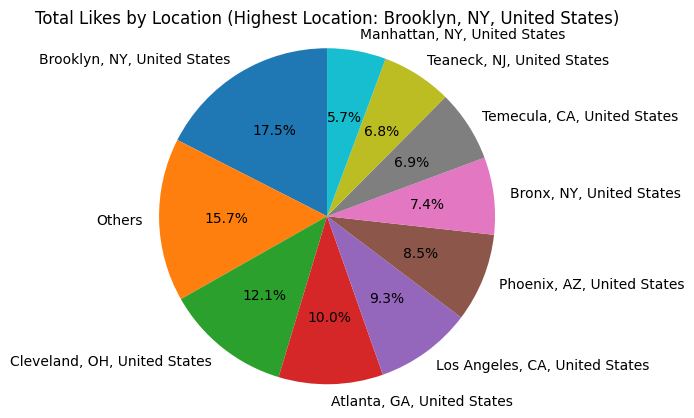

In [38]:
import re
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, isnan, sum
import pandas as pd

# plus 1 to like because though one tweet without likes still reflects attention
df = df.withColumn("likes", col("likes") + lit(1))

# filter out rows with no location, numeric location, or NaN location
df_filtered = df.filter((col("location") != "No location available.") & (~isnan("location")) & (col("location") != "") & ~(col("location").rlike('\d+')) & ~(col("location").rlike('^\W+$')))

# group data by location and calculate total likes
likes_by_location = df_filtered.groupBy("location").agg(sum("likes").alias("total_likes"))

# fill any NaN values in the total_likes column with 0
likes_by_location_pd = likes_by_location.toPandas().fillna(0)

# combine locations with little likes together as "Others"
others_likes = likes_by_location_pd[likes_by_location_pd["total_likes"] < 5]["total_likes"].sum()
likes_by_location_pd = likes_by_location_pd[likes_by_location_pd["total_likes"] >= 5]
likes_by_location_pd.loc[len(likes_by_location_pd)] = ["Others", others_likes]

# sort the dataframe by total_likes column in descending order
likes_by_location_pd.sort_values("total_likes", ascending=False, inplace=True)

# get the location text with the highest percentage
highest_loc = likes_by_location_pd.iloc[0]["location"]

N = 10  # number of top locations to display
top_locations = likes_by_location_pd.nlargest(N, "total_likes")
print(top_locations)

# create pie chart of likes by location using matplotlib
plt.pie(top_locations["total_likes"], labels=top_locations["location"], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title(f"Total Likes by Location (Highest Location: {highest_loc})")
plt.show()

In [39]:
import plotly.express as px
import pyspark.sql.functions as F

# create a new DataFrame to store the state names and total likes
state_likes = df_filtered.groupBy("location").agg(F.sum("likes").alias("total_likes"))
state_likes_pd = state_likes.toPandas()

# use regex to extract the state name from the location string
state_likes_pd["state"] = state_likes_pd["location"].str.extract(r',\s*([A-Z]{2})\s*\d*', expand=False)

# drop any rows with missing state names
state_likes_pd.dropna(subset=["state"], inplace=True)

# group by state and sum the total likes
state_likes_pd = state_likes_pd.groupby("state").sum().reset_index()

# use plotly to create a US map with total likes data
fig = px.choropleth(state_likes_pd, locations="state", locationmode="USA-states", color="total_likes", scope="usa")
fig.show()

<ipython-input-39-147e98f25863>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_likes_pd = state_likes_pd.groupby("state").sum().reset_index()


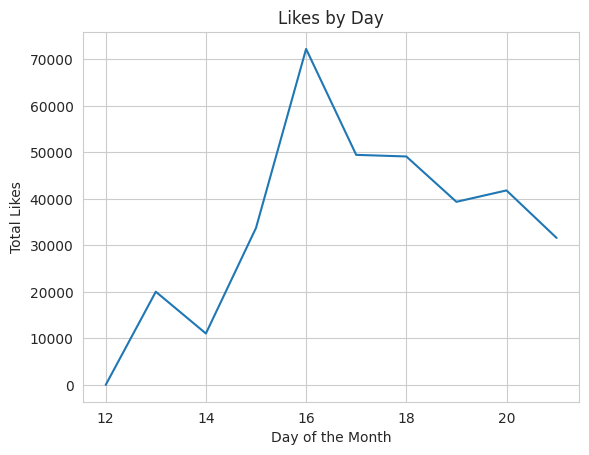

In [43]:
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# select only the columns we need
likes_by_day = df.select(F.dayofmonth("timestamp").alias("day"), "likes")

# group by day and sum the likes for each day
likes_by_day = likes_by_day.groupBy("day").agg(F.sum("likes").alias("total_likes"))

# convert to pandas dataframe for plotting
likes_by_day_pd = likes_by_day.toPandas()

# plot the data using seaborn
sns.set_style("whitegrid")
sns.lineplot(x="day", y="total_likes", data=likes_by_day_pd)
plt.xlabel("Day of the Month")
plt.ylabel("Total Likes")
plt.title("Likes by Day")
plt.show()

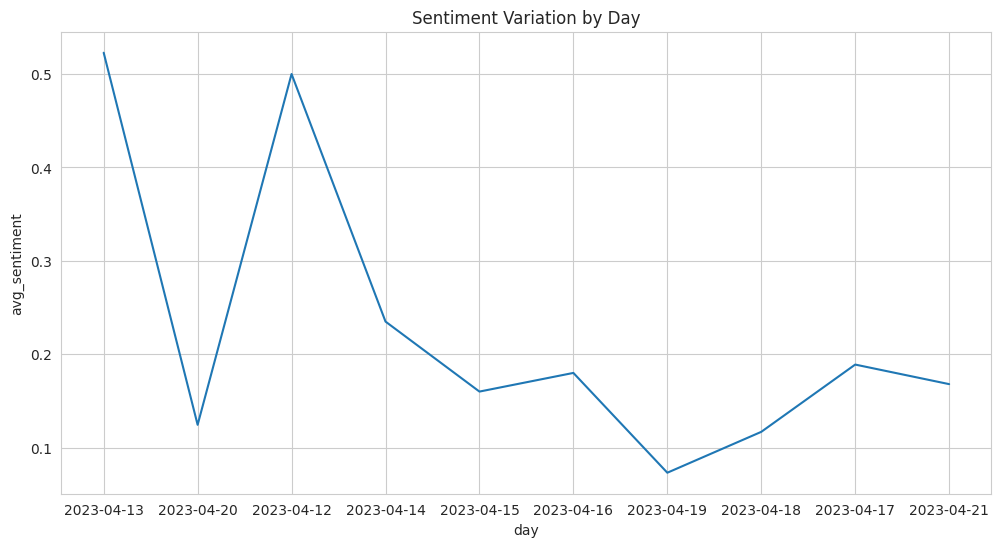

In [44]:
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# group by day and calculate average sentiment score
sentiment_by_day = df.groupBy(F.date_format('timestamp', 'yyyy-MM-dd').alias('day')).agg(F.avg('sentiment').alias('avg_sentiment'))

# convert to pandas dataframe for plotting
sentiment_by_day_pd = sentiment_by_day.toPandas()

sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.lineplot(data=sentiment_by_day_pd, x="day", y="avg_sentiment")
plt.title("Sentiment Variation by Day")

# let smaller date move forward
plt.gca().invert_xaxis()

plt.show()

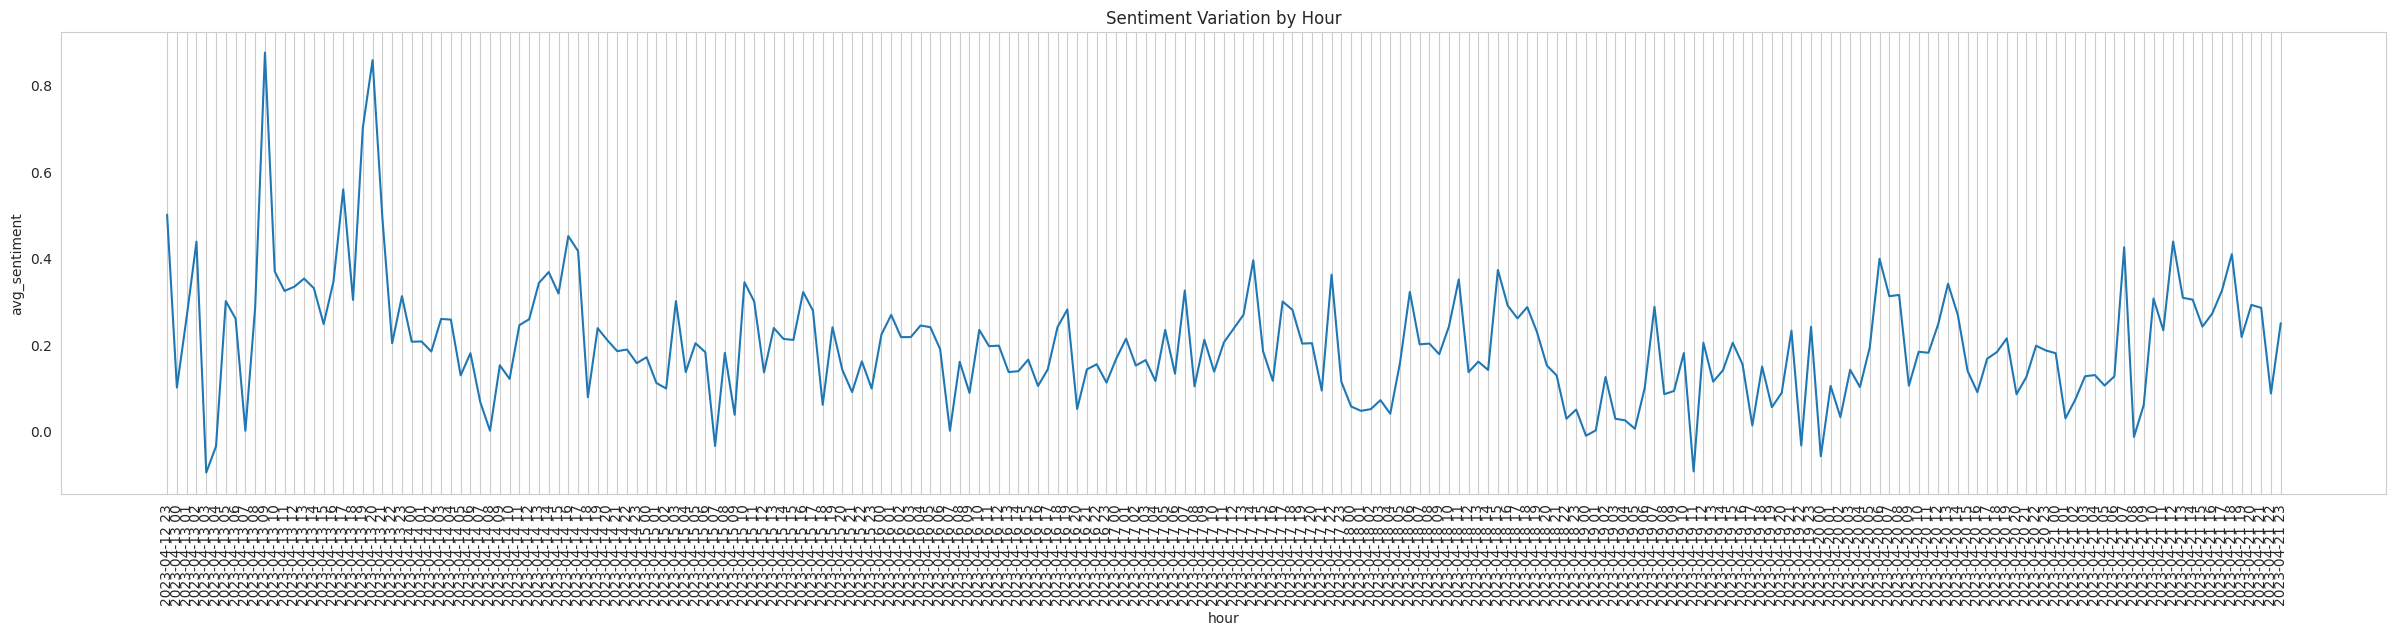

In [52]:
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# group by hour and calculate average sentiment score
sentiment_by_hour = df.groupBy(F.date_format('timestamp', 'yyyy-MM-dd HH').alias('hour')).agg(F.avg('sentiment').alias('avg_sentiment'))

# sort by hour in ascending order
sentiment_by_hour = sentiment_by_hour.sort("hour")

# convert to pandas dataframe for plotting
sentiment_by_hour_pd = sentiment_by_hour.toPandas()

sns.set_style("whitegrid")
plt.figure(figsize=(30,6))
sns.lineplot(data=sentiment_by_hour_pd, x="hour", y="avg_sentiment")
plt.xticks(rotation=90)
plt.title("Sentiment Variation by Hour")

plt.show()


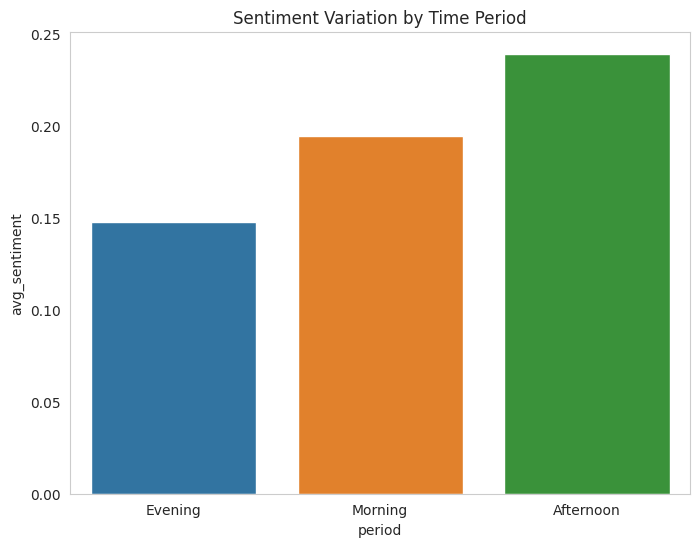

In [53]:
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# create an expression to convert timestamp to time period
time_period = F.when((F.hour('timestamp') >= 6) & (F.hour('timestamp') < 12), 'Morning') \
                .when((F.hour('timestamp') >= 12) & (F.hour('timestamp') < 18), 'Afternoon') \
                .otherwise('Evening')

# group by time period and calculate average sentiment score
sentiment_by_period = df.groupBy(time_period.alias('period')).agg(F.avg('sentiment').alias('avg_sentiment'))

# convert to pandas dataframe for plotting
sentiment_by_period_pd = sentiment_by_period.toPandas()

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(data=sentiment_by_period_pd, x="period", y="avg_sentiment")
plt.title("Sentiment Variation by Time Period")
plt.show()